In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/segmentation-full-body-mads-dataset/df.csv
/kaggle/input/segmentation-full-body-mads-dataset/segmentation_full_body_mads_dataset_1192_img/segmentation_full_body_mads_dataset_1192_img/images/HipHop_HipHop5_C0_00090.png
/kaggle/input/segmentation-full-body-mads-dataset/segmentation_full_body_mads_dataset_1192_img/segmentation_full_body_mads_dataset_1192_img/images/HipHop_HipHop1_C2_00675.png
/kaggle/input/segmentation-full-body-mads-dataset/segmentation_full_body_mads_dataset_1192_img/segmentation_full_body_mads_dataset_1192_img/images/HipHop_HipHop1_C1_00630.png
/kaggle/input/segmentation-full-body-mads-dataset/segmentation_full_body_mads_dataset_1192_img/segmentation_full_body_mads_dataset_1192_img/images/Sports_Badminton_C0_00540.png
/kaggle/input/segmentation-full-body-mads-dataset/segmentation_full_body_mads_dataset_1192_img/segmentation_full_body_mads_dataset_1192_img/images/Taichi_S2_C2_00810.png
/kaggle/input/segmentation-full-body-mads-dataset/segmentation_full_bod

In [2]:
import os
import numpy as np
import cv2
from glob import glob

In [3]:
import matplotlib.pyplot as plt
from PIL import Image

In [4]:
import tensorflow as tf
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Model
from tensorflow.keras.layers import (Input, Conv2D, MaxPooling2D, Dropout,
                                     Conv2DTranspose, concatenate)
from tensorflow.keras.optimizers import Adam

2025-06-07 06:50:32.027416: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1749279032.263369      19 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1749279032.327544      19 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [5]:
from sklearn.model_selection import train_test_split

In [6]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt

# Define paths
base_path = '/kaggle/input/segmentation-full-body-mads-dataset/segmentation_full_body_mads_dataset_1192_img/segmentation_full_body_mads_dataset_1192_img'
images_path = os.path.join(base_path, 'images')
masks_path = os.path.join(base_path, 'masks')

# List all image and mask file paths
image_files = sorted([os.path.join(images_path, fname) for fname in os.listdir(images_path)])
mask_files = sorted([os.path.join(masks_path, fname) for fname in os.listdir(masks_path)])


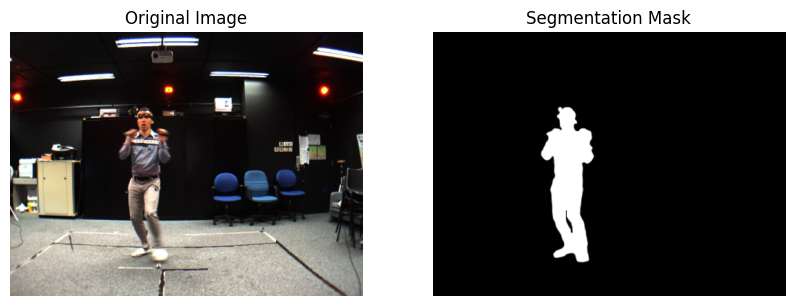

In [7]:
# Load and display one image and its mask
img = cv2.imread(image_files[0])
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

mask = cv2.imread(mask_files[0], cv2.IMREAD_GRAYSCALE)  # Usually binary or class mask

# Show both
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.title("Original Image")
plt.imshow(img)
plt.axis('off')

plt.subplot(1, 2, 2)
plt.title("Segmentation Mask")
plt.imshow(mask, cmap='gray')
plt.axis('off')
plt.show()

In [8]:
# Resize size
IMG_HEIGHT, IMG_WIDTH = 256, 256

X = []  # Images
Y = []  # Masks

for img_path, mask_path in zip(image_files, mask_files):
    # Read and resize image
    img = cv2.imread(img_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = cv2.resize(img, (IMG_WIDTH, IMG_HEIGHT))
    img = img / 255.0  # Normalize
    
    # Read and resize mask
    mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
    mask = cv2.resize(mask, (IMG_WIDTH, IMG_HEIGHT))
    mask = mask / 255.0  # Normalize to 0 or 1
    mask = np.expand_dims(mask, axis=-1)  # Add channel for compatibility
    
    X.append(img)
    Y.append(mask)

# Convert to numpy arrays
X = np.array(X, dtype=np.float32)
Y = np.array(Y, dtype=np.float32)

libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known inc

In [9]:
from sklearn.model_selection import train_test_split

X_train, X_val, Y_train, Y_val = train_test_split(
    X, Y, test_size=0.2, random_state=42)

In [10]:
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Dropout, Conv2DTranspose, concatenate
from tensorflow.keras.models import Model

def multi_unet_model(n_classes=1, IMG_HEIGHT=256, IMG_WIDTH=256, IMG_CHANNELS=3):
    inputs = Input((IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS))

    # Encoder
    c1 = Conv2D(16, (3, 3), activation='relu', padding='same')(inputs)
    c1 = Dropout(0.1)(c1)
    c1 = Conv2D(16, (3, 3), activation='relu', padding='same')(c1)
    p1 = MaxPooling2D((2, 2))(c1)

    c2 = Conv2D(32, (3, 3), activation='relu', padding='same')(p1)
    c2 = Dropout(0.1)(c2)
    c2 = Conv2D(32, (3, 3), activation='relu', padding='same')(c2)
    p2 = MaxPooling2D((2, 2))(c2)

    c3 = Conv2D(64, (3, 3), activation='relu', padding='same')(p2)
    c3 = Dropout(0.2)(c3)
    c3 = Conv2D(64, (3, 3), activation='relu', padding='same')(c3)
    p3 = MaxPooling2D((2, 2))(c3)

    c4 = Conv2D(128, (3, 3), activation='relu', padding='same')(p3)
    c4 = Dropout(0.2)(c4)
    c4 = Conv2D(128, (3, 3), activation='relu', padding='same')(c4)
    p4 = MaxPooling2D(pool_size=(2, 2))(c4)

    c5 = Conv2D(256, (3, 3), activation='relu', padding='same')(p4)
    c5 = Dropout(0.3)(c5)
    c5 = Conv2D(256, (3, 3), activation='relu', padding='same')(c5)

    # Decoder
    u6 = Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(c5)
    u6 = concatenate([u6, c4])
    c6 = Conv2D(128, (3, 3), activation='relu', padding='same')(u6)
    c6 = Dropout(0.2)(c6)
    c6 = Conv2D(128, (3, 3), activation='relu', padding='same')(c6)

    u7 = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(c6)
    u7 = concatenate([u7, c3])
    c7 = Conv2D(64, (3, 3), activation='relu', padding='same')(u7)
    c7 = Dropout(0.2)(c7)
    c7 = Conv2D(64, (3, 3), activation='relu', padding='same')(c7)

    u8 = Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same')(c7)
    u8 = concatenate([u8, c2])
    c8 = Conv2D(32, (3, 3), activation='relu', padding='same')(u8)
    c8 = Dropout(0.1)(c8)
    c8 = Conv2D(32, (3, 3), activation='relu', padding='same')(c8)

    u9 = Conv2DTranspose(16, (2, 2), strides=(2, 2), padding='same')(c8)
    u9 = concatenate([u9, c1])
    c9 = Conv2D(16, (3, 3), activation='relu', padding='same')(u9)
    c9 = Dropout(0.1)(c9)
    c9 = Conv2D(16, (3, 3), activation='relu', padding='same')(c9)

    # Output Layer
    outputs = Conv2D(n_classes, (1, 1), activation='sigmoid')(c9)

    model = Model(inputs=[inputs], outputs=[outputs])
    return model

In [11]:
# Your U-Net function should already be defined as multi_unet_model

# Initialize the model (1 output channel for binary segmentation)
model = multi_unet_model(n_classes=1, IMG_HEIGHT=256, IMG_WIDTH=256, IMG_CHANNELS=3)

# Compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Display model summary
model.summary()


I0000 00:00:1749279083.495000      19 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 13942 MB memory:  -> device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5
I0000 00:00:1749279083.495865      19 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 13942 MB memory:  -> device: 1, name: Tesla T4, pci bus id: 0000:00:05.0, compute capability: 7.5


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 256, 256, 3)    │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d (Conv2D)           │ (None, 256, 256, 16)   │            448 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout (Dropout)         │ (None, 256, 256, 16)   │              0 │ conv2d[0][0]           │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_1 (Conv2D)         │ (None, 256, 256, 16)   │          2,320 │ dropout[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d             │ (None, 128, 128, 16)   │              0 │ conv2d_1[0][0]         │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_2 (Conv2D)         │ (None, 128, 128, 32)   │          4,640 │ max_pooling2d[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_1 (Dropout)       │ (None, 128, 128, 32)   │              0 │ conv2d_2[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_3 (Conv2D)         │ (None, 128, 128, 32)   │          9,248 │ dropout_1[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_1           │ (None, 64, 64, 32)     │              0 │ conv2d_3[0][0]         │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_4 (Conv2D)         │ (None, 64, 64, 64)     │         18,496 │ max_pooling2d_1[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_2 (Dropout)       │ (None, 64, 64, 64)     │              0 │ conv2d_4[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_5 (Conv2D)         │ (None, 64, 64, 64)     │         36,928 │ dropout_2[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_2           │ (None, 32, 32, 64)     │              0 │ conv2d_5[0][0]         │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_6 (Conv2D)         │ (None, 32, 32, 128)    │         73,856 │ max_pooling2d_2[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_3 (Dropout)       │ (None, 32, 32, 128)    │              0 │ conv2d_6[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_7 (Conv2D)         │ (None, 32, 32, 128)    │        147,584 │ dropout_3[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_3           │ (None, 16, 16, 128)    │              0 │ conv2d_7[0][0]         │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_8 (Conv2D)    

 Total params: 1,941,105 (7.40 MB)

 Trainable params: 1,941,105 (7.40 MB)

 Non-trainable params: 0 (0.00 B)

In [12]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

# Callback to stop training when val_loss doesn't improve for 5 epochs
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Optional: Save the best model based on val_loss
model_checkpoint = ModelCheckpoint('best_model.h5', monitor='val_loss', save_best_only=True)

# Train with callbacks
history = model.fit(
    X_train, Y_train,
    validation_data=(X_val, Y_val),
    batch_size=16,
    epochs=25,
    callbacks=[early_stopping, model_checkpoint],
    verbose=1
)


Epoch 1/25


/usr/local/lib/python3.11/dist-packages/keras/src/models/functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor']
Received: inputs=Tensor(shape=(None, 256, 256, 3))
  warnings.warn(msg)
I0000 00:00:1749279096.828678      67 service.cc:148] XLA service 0x7ea3f002d2e0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1749279096.829658      67 service.cc:156]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
I0000 00:00:1749279096.829685      67 service.cc:156]   StreamExecutor device (1): Tesla T4, Compute Capability 7.5
I0000 00:00:1749279097.963689      67 cuda_dnn.cc:529] Loaded cuDNN version 90300
I0000 00:00:1749279116.458312      67 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


60/60 ━━━━━━━━━━━━━━━━━━━━ 61s 528ms/step - accuracy: 0.7411 - loss: 0.5067 - val_accuracy: 0.9459 - val_loss: 0.1659
Epoch 2/25
60/60 ━━━━━━━━━━━━━━━━━━━━ 8s 139ms/step - accuracy: 0.9480 - loss: 0.1356 - val_accuracy: 0.9459 - val_loss: 0.0662
Epoch 3/25
60/60 ━━━━━━━━━━━━━━━━━━━━ 8s 139ms/step - accuracy: 0.9635 - loss: 0.0541 - val_accuracy: 0.9690 - val_loss: 0.0399
Epoch 4/25
60/60 ━━━━━━━━━━━━━━━━━━━━ 8s 140ms/step - accuracy: 0.9699 - loss: 0.0398 - val_accuracy: 0.9697 - val_loss: 0.0371
Epoch 5/25
60/60 ━━━━━━━━━━━━━━━━━━━━ 8s 141ms/step - accuracy: 0.9735 - loss: 0.0330 - val_accuracy: 0.9719 - val_loss: 0.0289
Epoch 6/25
60/60 ━━━━━━━━━━━━━━━━━━━━ 9s 142ms/step - accuracy: 0.9747 - loss: 0.0280 - val_accuracy: 0.9736 - val_loss: 0.0237
Epoch 7/25
60/60 ━━━━━━━━━━━━━━━━━━━━ 9s 143ms/step - accuracy: 0.9777 - loss: 0.0249 - val_accuracy: 0.9740 - val_loss: 0.0224
Epoch 8/25
60/60 ━━━━━━━━━━━━━━━━━━━━ 9s 144ms/step - accuracy: 0.9788 - loss: 0.0208 - val_accuracy: 0.9749 - val

In [13]:
X_train, X_test, Y_train, Y_test = train_test_split(
    X_train, Y_train, test_size=0.1, random_state=42)

In [14]:
loss, accuracy = model.evaluate(X_test, Y_test)
print(f"Test Loss: {loss:.4f}")
print(f"Test Accuracy: {accuracy:.4f}")

3/3 ━━━━━━━━━━━━━━━━━━━━ 7s 85ms/step - accuracy: 0.9812 - loss: 0.0101
Test Loss: 0.0101
Test Accuracy: 0.9813


In [15]:
preds = model.predict(X_val)
preds_thresholded = (preds > 0.5).astype(np.uint8)

/usr/local/lib/python3.11/dist-packages/keras/src/models/functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor']
Received: inputs=Tensor(shape=(32, 256, 256, 3))
  warnings.warn(msg)


8/8 ━━━━━━━━━━━━━━━━━━━━ 2s 198ms/step


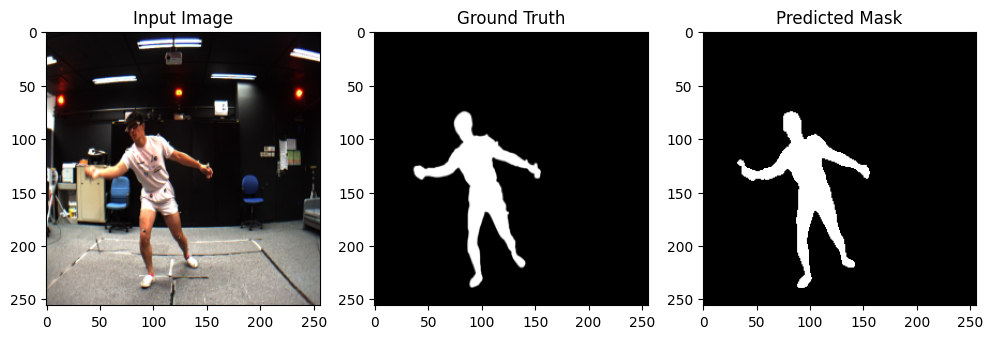

In [16]:
import matplotlib.pyplot as plt

def display_sample(i):
    plt.figure(figsize=(12, 4))

    plt.subplot(1, 3, 1)
    plt.imshow(X_val[i])
    plt.title('Input Image')
    
    plt.subplot(1, 3, 2)
    plt.imshow(np.squeeze(Y_val[i]), cmap='gray')
    plt.title('Ground Truth')

    plt.subplot(1, 3, 3)
    plt.imshow(np.squeeze(preds_thresholded[i]), cmap='gray')
    plt.title('Predicted Mask')

    plt.show()

# Example: Show prediction for 5th image
display_sample(6)


In [17]:
i = 6
image = X_test[i]
mask_true = Y_test[i]

# Predict mask
pred_mask = model.predict(np.expand_dims(image, axis=0))[0]

# Threshold if needed
pred_mask = (pred_mask > 0.5).astype(np.uint8)

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


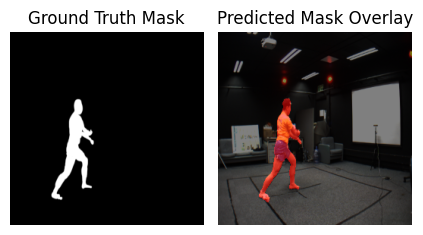

In [18]:
import matplotlib.pyplot as plt

def overlay_mask_on_image(image, mask, alpha=0.5, color=[255, 0, 0]):
    # Convert to RGB if grayscale
    if image.shape[-1] == 1:
        image = np.repeat(image, 3, axis=-1)

    # Normalize image if needed
    if image.max() > 1.0:
        image = image / 255.0

    # Create a color mask
    colored_mask = np.zeros_like(image)
    for i in range(3):
        colored_mask[:, :, i] = mask[:, :, 0] * color[i] / 255.0

    # Overlay the mask
    overlayed = image * (1 - alpha) + colored_mask * alpha
    return overlayed

# Overlay prediction on original image
overlayed = overlay_mask_on_image(image, pred_mask)

plt.subplot(1, 3, 2)
plt.title("Ground Truth Mask")
plt.imshow(mask_true[:, :, 0], cmap='gray')
plt.axis('off')

plt.subplot(1, 3, 3)
plt.title("Predicted Mask Overlay")
plt.imshow(overlayed)
plt.axis('off')

plt.tight_layout()
plt.show()

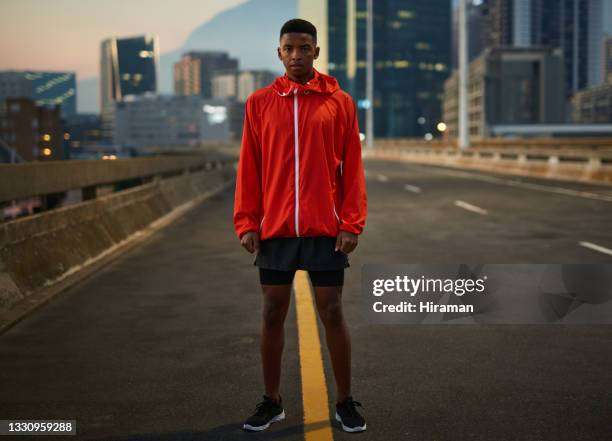